In [1]:
import numpy as np
import orqviz
import matplotlib.pyplot as plt

Given this "mysterious loss function named *loss_function*, what can we find out about it?

In [2]:
def loss_function(pars):
    norm_of_pars = np.linalg.norm(pars, ord=2)
    freq = 2
    return -np.sin(freq*norm_of_pars) / (freq*norm_of_pars) + 1

n_dimensions = 4

loss_limits = (-0.1, 1.3)

title_fontsize = 18
label_fontsize = 18 
tick_fontsize = 15
colorbar_fontsize = 17
legend_fontsize = 16

Let's get some gradients going

In [3]:
from gradient_descent_optimizer import gradient_descent_optimizer
from orqviz.gradients import calculate_full_gradient

gradient_function = lambda pars: calculate_full_gradient(pars, loss_function, eps=1e-3, stochastic=False)

And do 50 repetitions!

In [4]:
all_parameter_trajectories = []
all_costs = []

np.random.seed(123)

for _ in range(100):

    init_params = np.random.uniform(-5, 5, size=n_dimensions)
    parameter_trajectory, costs = gradient_descent_optimizer(init_params=init_params, loss_function=loss_function, 
                                                             n_iters=150, learning_rate=0.2,
                                                             full_gradient_function=gradient_function)
    all_parameter_trajectories.append(parameter_trajectory)
    all_costs.append(costs)
    
all_parameter_trajectories = np.array(all_parameter_trajectories)
all_final_parameters = all_parameter_trajectories[:,-1]
all_costs = np.array(all_costs)

sorted_indices = np.argsort(all_costs[:,-1])
all_parameter_trajectories = all_parameter_trajectories[sorted_indices]
all_final_parameters = all_parameter_trajectories[:,-1]
all_costs = all_costs[sorted_indices]

What do we now now? We know the training progress...

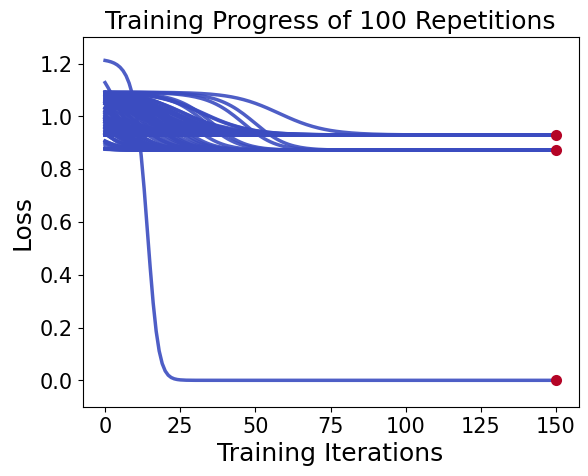

In [5]:
plt.plot(all_costs.T, linewidth=2.5, color=plt.get_cmap("coolwarm", 7)(0), alpha=0.9)

plt.title("Training Progress of 100 Repetitions", fontsize=title_fontsize)
plt.ylabel("Loss", fontsize=label_fontsize)
plt.xlabel("Training Iterations", fontsize=label_fontsize)
plt.tick_params(labelsize=tick_fontsize)
plt.ylim(loss_limits)
plt.scatter([150, 150, 150], all_costs[[0, 1, -1],-1], color=plt.get_cmap("coolwarm", 7)(6), linewidth=2, zorder=3)

plt.show()


...and the final local minima.

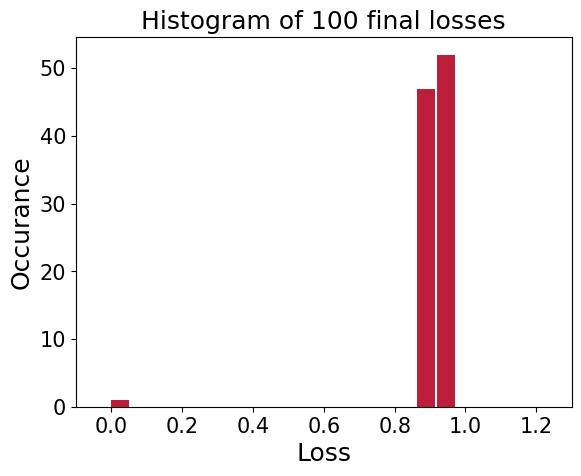

In [6]:
plt.hist(all_costs[:,-1], bins=100, width=0.05, align="mid", color=plt.get_cmap("coolwarm", 7)(6), alpha=0.9)
plt.title("Histogram of 100 final losses", fontsize=title_fontsize)
plt.xlabel("Loss", fontsize=label_fontsize)
plt.ylabel("Occurance", fontsize=label_fontsize)
plt.tick_params(labelsize=tick_fontsize)
plt.xlim(loss_limits)

plt.show()


This is solid information, however, we have no idea what the loss function really does, how the landscape looks like, etc.\
We have barely found out the losses of local minima. The distribution of those is very discrete, which is extremely valuable, to be fair. But can we do better?

### 1D Interpolation

In [7]:
from orqviz.scans import perform_1D_interpolation, plot_1D_interpolation_result

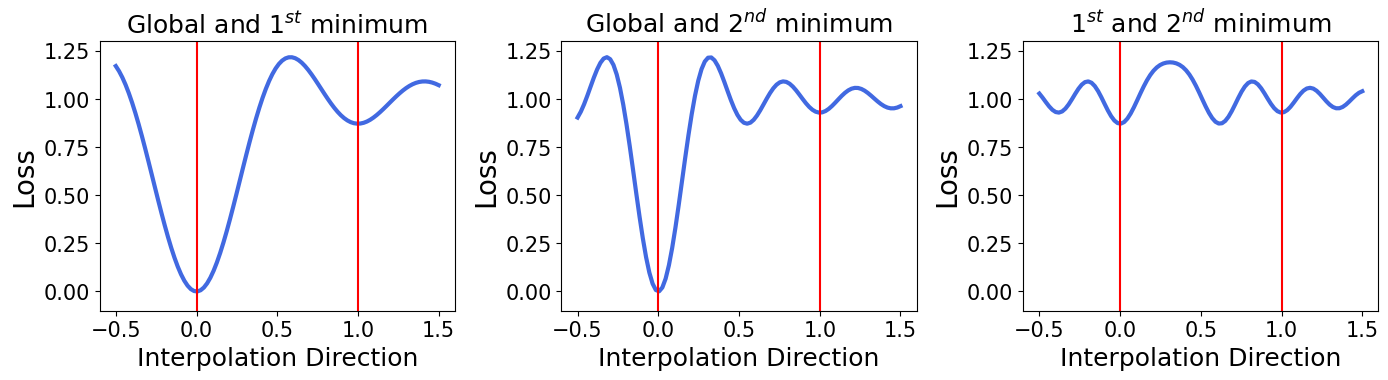

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(16.5 ,3.5), gridspec_kw=dict(wspace=0.3))
(ax1, ax2, ax3) = axes

pairs = [(0,1), (0,-1), (1, -1)]

for ax, pair in zip(axes, pairs):
    scan1D_result = perform_1D_interpolation(all_final_parameters[pair[0]], 
                                             all_final_parameters[pair[1]], 
                                             loss_function, n_steps=100)
    plot_1D_interpolation_result(scan1D_result, ax=ax)

    ax.tick_params(labelsize=tick_fontsize)
    ax.set_xlabel("Interpolation Direction", fontsize=label_fontsize)
    ax.set_ylabel("Loss", fontsize=label_fontsize+2)
    ax.set_ylim(loss_limits)
    
ax1.set_title("Global and $1^{st}$ minimum", fontsize=title_fontsize)
ax2.set_title("Global and $2^{nd}$ minimum", fontsize=title_fontsize)
ax3.set_title("$1^{st}$ and $2^{nd}$ minimum", fontsize=title_fontsize)

plt.show()


### 2D Interpolation

In [9]:
from orqviz.scans import perform_2D_interpolation, plot_2D_interpolation_result
from orqviz.plot_utils import normalize_color_and_colorbar, get_colorbar_from_ax

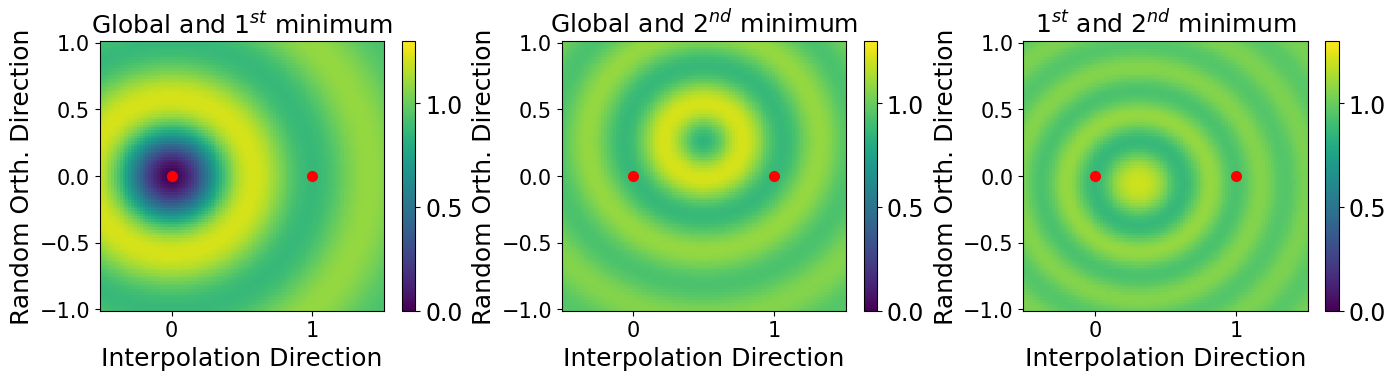

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16.5 ,3.5), gridspec_kw=dict(wspace=0.3))
(ax1, ax2, ax3) = axes
pairs = [(0,1), (1,2), (1,-1)]

for ax, pair in zip(axes, pairs):
    scan2D_result = perform_2D_interpolation(all_final_parameters[pair[0]], 
                                             all_final_parameters[pair[1]], 
                                             loss_function, n_steps_x=100, end_points_x=(-0.5, 1.5), end_points_y=(-1, 1))
    plot_2D_interpolation_result(scan2D_result, fig=fig, ax=ax)

    normalize_color_and_colorbar(fig, ax, min_val=0, max_val=loss_limits[1])
    cbar = get_colorbar_from_ax(ax)
    cbar.ax.tick_params(labelsize=colorbar_fontsize)
    ax.tick_params(labelsize=tick_fontsize)
    ax.set_xlabel("Interpolation Direction", fontsize=label_fontsize)
    ax.set_ylabel("Random Orth. Direction", fontsize=label_fontsize)
    
ax1.set_title("Global and $1^{st}$ minimum", fontsize=title_fontsize)
ax2.set_title("Global and $2^{nd}$ minimum", fontsize=title_fontsize)
ax3.set_title("$1^{st}$ and $2^{nd}$ minimum", fontsize=title_fontsize)

plt.show()


What do we know so far? We have a general idea that the loss function is somewhat periodic and concentric.\
We can also check how the training trajectories look like, i.e. which space the gradient descent traversed:

### PCA Scans

In [11]:
from orqviz.pca import get_pca, perform_2D_pca_scan, plot_pca_landscape, plot_scatter_points_on_pca

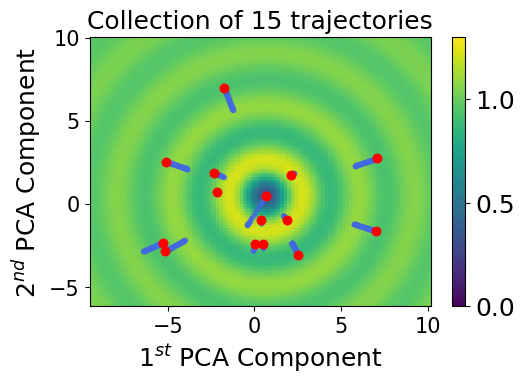

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5.5 ,3.5))
whiches = np.append(np.arange(0,8), np.arange(-8,-1), axis=0)
pca = get_pca(np.concatenate([all_parameter_trajectories[which] for which in whiches], axis=0))
scanpca_result = perform_2D_pca_scan(pca, loss_function, n_steps_x=100, offset=3)
plot_pca_landscape(scanpca_result, pca)
for which in whiches:
    plot_scatter_points_on_pca(all_parameter_trajectories[which], pca, color="royalblue", alpha=0.5)
    plot_scatter_points_on_pca([all_final_parameters[which]], pca, color="red", alpha=1., s=150)

normalize_color_and_colorbar(fig, ax, 0., 1.3)
ax.set_xlabel("$1^{st}$ PCA Component", fontsize=label_fontsize)
ax.set_ylabel("$2^{nd}$ PCA Component", fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)
cbar = get_colorbar_from_ax(ax)

cbar.ax.tick_params(labelsize=label_fontsize)
plt.title("Collection of 15 trajectories", fontsize=title_fontsize)

plt.show()

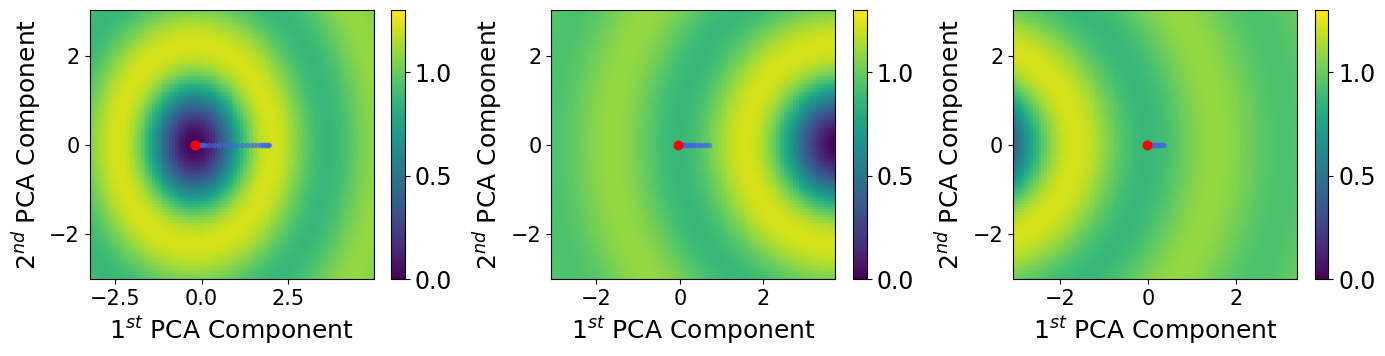

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(16.5 ,3.5), gridspec_kw=dict(wspace=0.3))
whiches = [0, 1, 2]

for ax, which in zip(axes, whiches):
    pca = get_pca(all_parameter_trajectories[which])
    scanpca_result = perform_2D_pca_scan(pca, loss_function, n_steps_x=100, offset=3)
    plot_pca_landscape(scanpca_result, pca, fig=fig, ax=ax)
    plot_scatter_points_on_pca(all_parameter_trajectories[which], pca, color="royalblue", alpha=0.5, ax=ax)
    plot_scatter_points_on_pca([all_final_parameters[which]], pca, color="red", alpha=1., ax=ax, s=150)
    normalize_color_and_colorbar(fig, ax, 0., 1.3)
    ax.set_xlabel("$1^{st}$ PCA Component", fontsize=label_fontsize)
    ax.set_ylabel("$2^{nd}$ PCA Component", fontsize=label_fontsize)
    ax.tick_params(labelsize=tick_fontsize)
    cbar = get_colorbar_from_ax(ax)
    cbar.ax.tick_params(labelsize=colorbar_fontsize)
plt.show()

And now with two trajectories at a time:

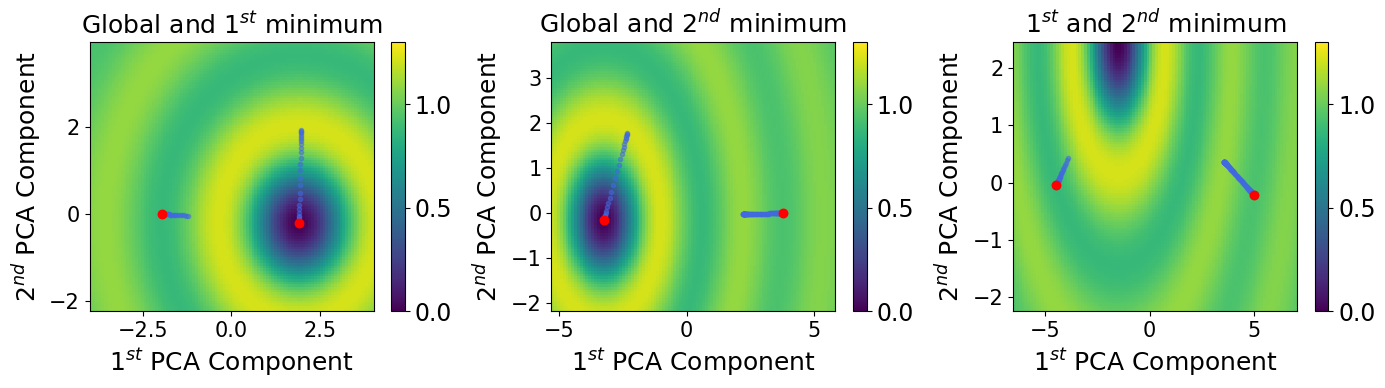

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(16.5 ,3.5), gridspec_kw=dict(wspace=0.3))
(ax1, ax2, ax3) = axes

pairs = [(0,1), (0,-1), (1, -1)]

for ax, pair in zip(axes, pairs):
    pca = get_pca(np.append(all_parameter_trajectories[pair[0]],all_parameter_trajectories[pair[1]], axis=0))
    scanpca_result = perform_2D_pca_scan(pca, loss_function, n_steps_x=100, offset=2)
    plot_pca_landscape(scanpca_result, pca, fig=fig, ax=ax)
    plot_scatter_points_on_pca(all_parameter_trajectories[pair[0]], pca, ax=ax, color="royalblue", alpha=0.5,)
    plot_scatter_points_on_pca(all_parameter_trajectories[pair[1]], pca, ax=ax, color="royalblue", alpha=0.5)
    plot_scatter_points_on_pca([all_final_parameters[pair[0]]], pca, color="red", alpha=1., ax=ax, s=150)
    plot_scatter_points_on_pca([all_final_parameters[pair[1]]], pca, color="red", alpha=1., ax=ax, s=150)
    normalize_color_and_colorbar(fig, ax, min_val=0, max_val=loss_limits[1])
    cbar = get_colorbar_from_ax(ax)
    cbar.ax.tick_params(labelsize=colorbar_fontsize)
    ax.tick_params(labelsize=tick_fontsize)
    ax.set_xlabel("$1^{st}$ PCA Component", fontsize=label_fontsize)
    ax.set_ylabel("$2^{nd}$ PCA Component", fontsize=label_fontsize)
    
ax1.set_title("Global and $1^{st}$ minimum", fontsize=title_fontsize)
ax2.set_title("Global and $2^{nd}$ minimum", fontsize=title_fontsize)
ax3.set_title("$1^{st}$ and $2^{nd}$ minimum", fontsize=title_fontsize)

plt.show()


Surprisingly straight paths! This indicates that the landscape is locally highly convex. This can be tested with the Hessian!

### Hessians

In [15]:
from orqviz.hessians import get_Hessian, perform_1D_hessian_eigenvector_scan, plot_1D_hessian_eigenvector_scan_result

Lets first look at the eigenvalues

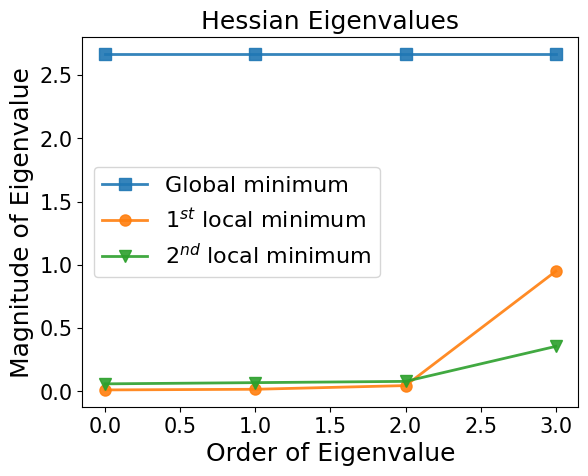

In [16]:
hessian0 = get_Hessian(all_final_parameters[0], loss_function, eps=1e-3)
hessian1 = get_Hessian(all_final_parameters[1], loss_function, eps=1e-3)
hessian_1 = get_Hessian(all_final_parameters[-1], loss_function, eps=1e-3)
    
plt.plot(hessian0.eigenvalues, label="Global minimum", alpha=0.9, linewidth=2, marker="s", ms=8)
plt.plot(hessian1.eigenvalues, label="$1^{st}$ local minimum", alpha=0.9, linewidth=2, marker="o", ms=8)
plt.plot(hessian_1.eigenvalues, label="$2^{nd}$ local minimum", alpha=0.9, linewidth=2, marker="v", ms=8)
# plt.ylim(-0.01, 1.5)
plt.legend(fontsize=legend_fontsize, loc="center left")
plt.title("Hessian Eigenvalues", fontsize=title_fontsize)
plt.ylabel("Magnitude of Eigenvalue", fontsize=label_fontsize)
plt.xlabel("Order of Eigenvalue", fontsize=label_fontsize)
plt.tick_params(labelsize=tick_fontsize)

plt.show()


Interestingly, the global minimum has four equal eigenvalues, and all are positive. The other minima have at least one eigenvalue which is zero eigenvalues. This shows that there is at least one direction in which the landscape is locally flat. Can we see this in 1D scans in the direction of the eigenvectors?

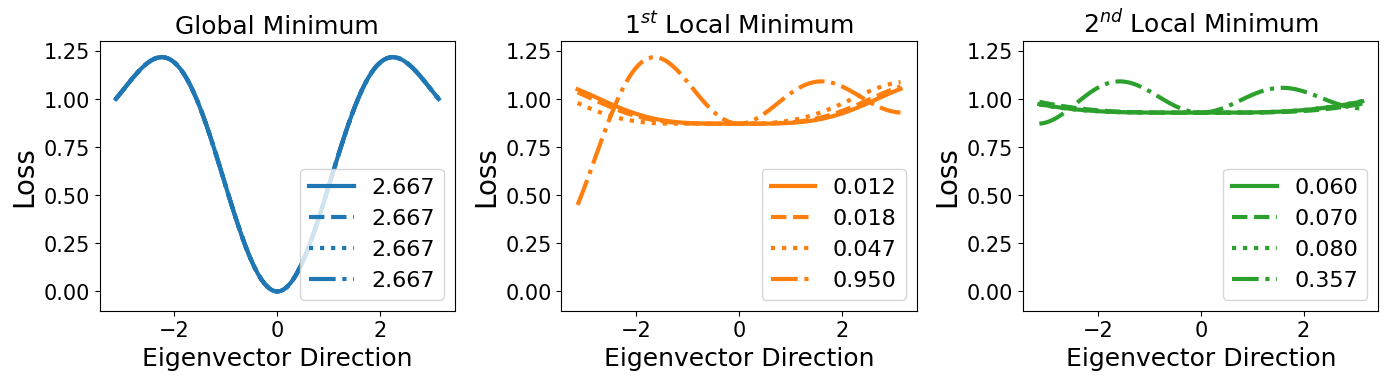

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(16.5, 3.5), gridspec_kw=dict(wspace=0.3))
(ax1, ax2, ax3) = axes
#

styles = ["solid", 
          "dashed", 
          "dotted",
          "dashdot",
         ]
list_of_scans0 = perform_1D_hessian_eigenvector_scan(hessian0, loss_function, n_points=101)
for ii in range(len(list_of_scans0)):
    plot_1D_hessian_eigenvector_scan_result([list_of_scans0[ii]], [hessian0.eigenvalues[ii]], linestyle=styles[ii], 
                                            ax=ax1, color="tab:blue")

list_of_scans1 = perform_1D_hessian_eigenvector_scan(hessian1, loss_function, n_points=101)
for ii in range(len(list_of_scans1)):
    plot_1D_hessian_eigenvector_scan_result([list_of_scans1[ii]], [hessian1.eigenvalues[ii]], linestyle=styles[ii], 
                                            ax=ax2, color="tab:orange")

list_of_scans_1 = perform_1D_hessian_eigenvector_scan(hessian_1, loss_function, n_points=101)
for ii in range(len(list_of_scans_1)):
    plot_1D_hessian_eigenvector_scan_result([list_of_scans_1[ii]], [hessian_1.eigenvalues[ii]], linestyle=styles[ii], 
                                            ax=ax3, color="tab:green")

for ax in axes:
    ax.set_ylim(loss_limits)
    ax.set_ylabel("Loss", fontsize=label_fontsize+2)
    ax.set_xlabel("Eigenvector Direction", fontsize=label_fontsize)
    ax.tick_params(labelsize=tick_fontsize)
    ax.legend(fontsize=legend_fontsize, loc="lower right")

ax1.set_title("Global Minimum", fontsize=title_fontsize)
ax2.set_title("$1^{st}$ Local Minimum", fontsize=title_fontsize)
ax3.set_title("$2^{nd}$ Local Minimum", fontsize=title_fontsize)

plt.show()


Apparently, from the global minimum it goes straight up in every direction! This is not the case for the other two minima. However, we see that some directions are significantly flatter. 

In [18]:
from orqviz.scans import perform_2D_scan, plot_2D_scan_result

Let's try 2D Hessian eigenvector scans in the 

First in the low eigenvalue directions:


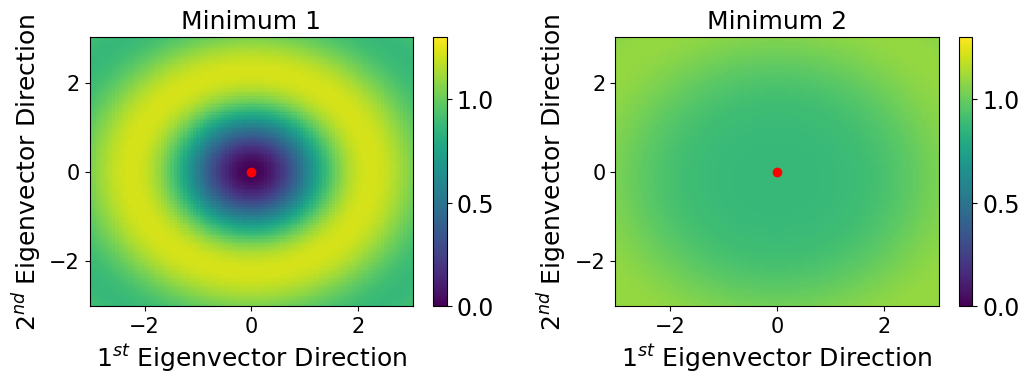

Now in the high eigenvector directions:


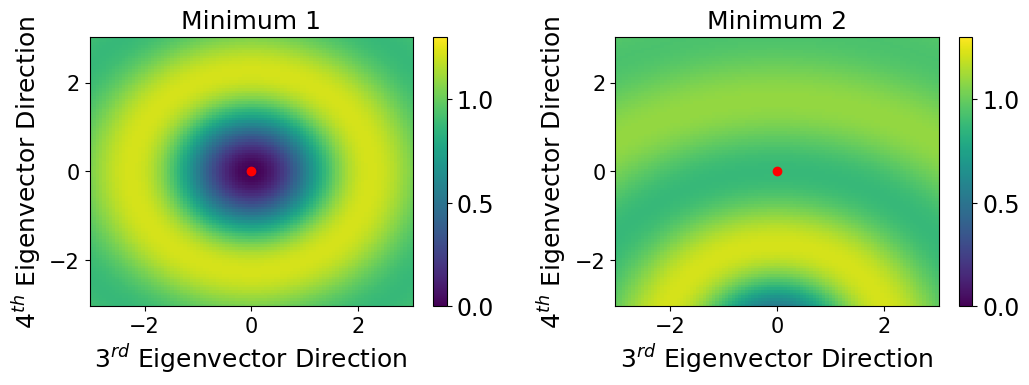

In [19]:
factor = 3
whiches = [0,1]
##
fig, axes = plt.subplots(1, 2, figsize=(12,3.5), gridspec_kw=dict(wspace=0.3))
(ax1, ax2) = axes
print("First in the low eigenvalue directions:")
for ax, which, hess in zip(axes, whiches, [hessian0, hessian1, hessian_1]):
    scan2D_result = perform_2D_scan(all_final_parameters[which], loss_function, 
                                   direction_x=hess.eigenvectors[0]*factor, 
                                   direction_y=hess.eigenvectors[1]*factor, 
                                    n_steps_x=100)
    plot_2D_scan_result(scan2D_result, fig=fig, ax=ax)
    
    normalize_color_and_colorbar(fig, ax, min_val=0., max_val=loss_limits[1])
    ax.scatter(0,0, color="red")
    cbar = get_colorbar_from_ax(ax)
    cbar.ax.tick_params(labelsize=colorbar_fontsize)
    ax.tick_params(labelsize=tick_fontsize)
    ax.set_xlabel("$1^{st}$ Eigenvector Direction", fontsize=label_fontsize)
    ax.set_ylabel("$2^{nd}$ Eigenvector Direction", fontsize=label_fontsize)
ax1.set_title("Minimum 1", fontsize=title_fontsize)
ax2.set_title("Minimum 2", fontsize=title_fontsize)

plt.show()

fig, axes = plt.subplots(1,2, figsize=(12, 3.5), gridspec_kw=dict(wspace=0.3))
(ax1, ax2) = axes
print("Now in the high eigenvector directions:")
for ax, which, hess in zip(axes, whiches, [hessian0, hessian1, hessian_1]):
    scan2D_result = perform_2D_scan(all_final_parameters[which], loss_function, 
                                   direction_x=hess.eigenvectors[0]*factor, 
                                   direction_y=hess.eigenvectors[-1]*factor, 
                                    n_steps_x=100)
    plot_2D_scan_result(scan2D_result, fig=fig, ax=ax)
    
    normalize_color_and_colorbar(fig, ax, min_val=0., max_val=loss_limits[1])
    ax.scatter(0,0, color="red")
    cbar = get_colorbar_from_ax(ax)
    cbar.ax.tick_params(labelsize=colorbar_fontsize)
    ax.tick_params(labelsize=tick_fontsize)
    ax.set_xlabel("$3^{rd}$ Eigenvector Direction", fontsize=label_fontsize)
    ax.set_ylabel("$4^{th}$ Eigenvector Direction", fontsize=label_fontsize)
ax1.set_title("Minimum 1", fontsize=title_fontsize)
ax2.set_title("Minimum 2", fontsize=title_fontsize)

plt.show()

This is not too much information that we didn't already know, but those flat directions indicated by the Hessian eigenvales and by the scans look interesting. Unfortunately, the straight 1D scans didn't reveal too much...\
Luckily, we have a tool to scan non-linearly - the Nudged Elastic Band!

### Nudged Elastic Band

In [20]:
from orqviz.elastic_band import Chain, ChainPath, run_AutoNEB

The initial trajectories are linear interpolations between the points

In [21]:
lin_chain01 = Chain(np.linspace(all_final_parameters[0], all_final_parameters[1], num=5))
lin_path01 = ChainPath(lin_chain01)
#
lin_chain12 = Chain(np.linspace(all_final_parameters[1], all_final_parameters[2], num=5))
lin_path12 = ChainPath(lin_chain12)

Now lets train!

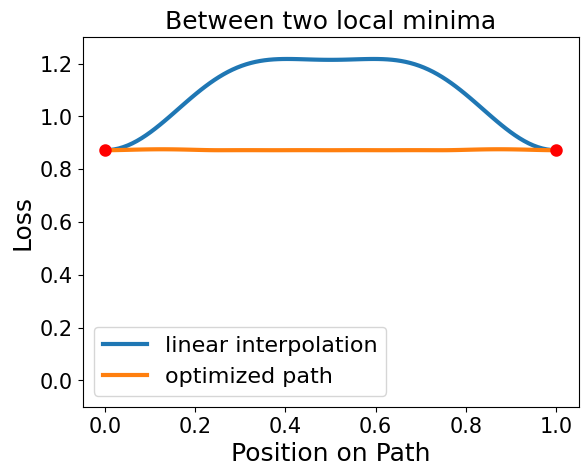

In [22]:
all_chains12 = run_AutoNEB(lin_chain12, loss_function, n_cycles=4, n_iters_per_cycle=100, max_new_pivots=2, 
                         weighted_redistribution=True, eps=1e-3, learning_rate=0.1, percentage_tol=0.1)
trained_chain12 = all_chains12[-1]
trained_path12 = ChainPath(trained_chain12)

plt.plot(np.linspace(0, 1, 100), lin_path12.evaluate_points_on_path(100, loss_function), label="linear interpolation", linewidth=3)
plt.plot(np.linspace(0, 1, 100), trained_path12.evaluate_points_on_path(100, loss_function), label="optimized path", linewidth=3)
plt.scatter([0,1], lin_chain12.evaluate_on_pivots(loss_function)[[0,-1]], color="red", linewidth=3, zorder=3)
fig = plt.gcf()
ax = fig.gca()
ax.set_xlabel("Position on Path", fontsize=label_fontsize)
ax.set_ylabel("Loss", fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.ylim(loss_limits)
plt.title("Between two local minima", fontsize=title_fontsize)

plt.show()


The space between them is flat!!!

In [23]:
from orqviz.pca import plot_line_through_points_on_pca

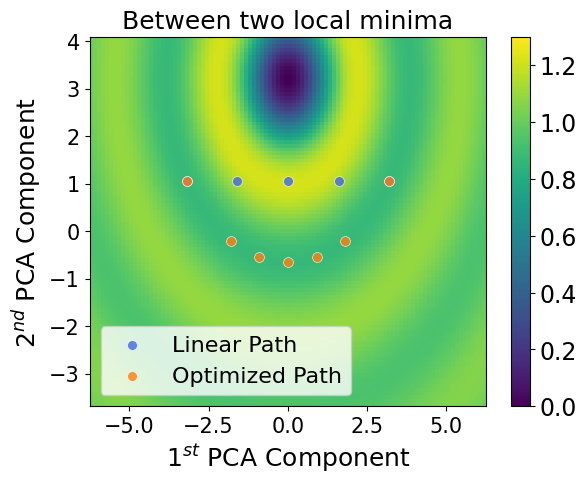

In [24]:
pca = get_pca(trained_chain12.pivots)
scanpca_result = perform_2D_pca_scan(pca, loss_function, n_steps_x=100, offset=3)
plot_pca_landscape(scanpca_result, pca)

plot_scatter_points_on_pca(lin_chain12.pivots, pca, color="royalblue", linewidth=0.5, edgecolor="white", s=200, label="Linear Path")
plot_scatter_points_on_pca(trained_chain12.pivots, pca, color="tab:orange", linewidth=0.5, edgecolor="white", s=200, label="Optimized Path")
fig = plt.gcf()
ax = fig.gca()
normalize_color_and_colorbar(fig, ax, 0, loss_limits[1])
ax.set_xlabel("$1^{st}$ PCA Component", fontsize=label_fontsize)
ax.set_ylabel("$2^{nd}$ PCA Component", fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)
cbar = get_colorbar_from_ax(ax)
cbar.ax.tick_params(labelsize=colorbar_fontsize)
plt.legend(loc="lower left", fontsize=legend_fontsize)
plt.title("Between two local minima", fontsize=title_fontsize)

plt.show()


And PCA scans tell us how. These tools all work in conjunction :)\
Last question, can we get into the global minimum from the first local minimum?

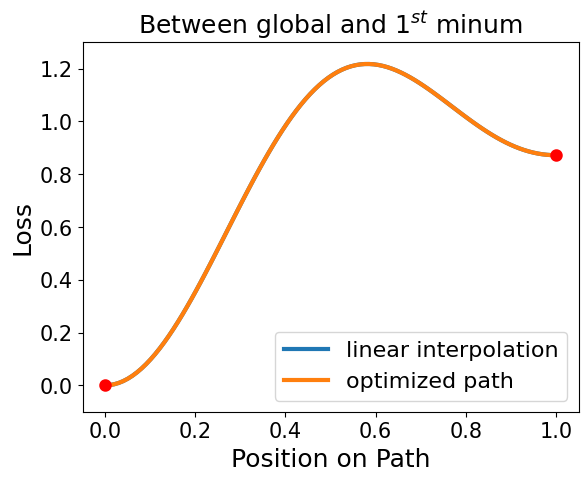

In [25]:
all_chains01 = run_AutoNEB(lin_chain01, loss_function, n_cycles=4, n_iters_per_cycle=100, max_new_pivots=2, 
                         weighted_redistribution=True, eps=1e-3, learning_rate=0.1, percentage_tol=0.1)
trained_chain01 = all_chains01[-1]
trained_path01 = ChainPath(trained_chain01)

# plt.plot(lin_path01.evaluate_points_on_path(100, loss_function), label="linear interpolation")
# plt.plot(trained_path01.evaluate_points_on_path(100, loss_function), label="optimized path")

plt.plot(np.linspace(0, 1, 100), lin_path01.evaluate_points_on_path(100, loss_function), label="linear interpolation", linewidth=3)
plt.plot(np.linspace(0, 1, 100), trained_path01.evaluate_points_on_path(100, loss_function), label="optimized path", linewidth=3)
plt.scatter([0,1], lin_chain01.evaluate_on_pivots(loss_function)[[0,-1]], color="red", linewidth=3, zorder=3)
fig = plt.gcf()
ax = fig.gca()
ax.set_xlabel("Position on Path", fontsize=label_fontsize)
ax.set_ylabel("Loss", fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.ylim(loss_limits)
plt.title("Between global and $1^{st}$ minum", fontsize=title_fontsize)

plt.show()

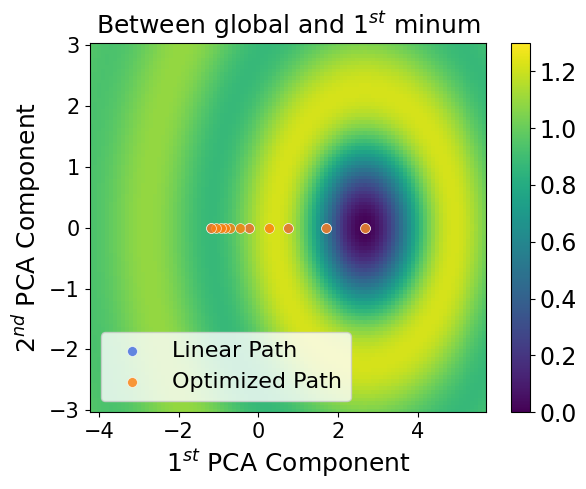

In [26]:
pca = get_pca(trained_chain01.pivots)
scanpca_result = perform_2D_pca_scan(pca, loss_function, n_steps_x=100, offset=3)
plot_pca_landscape(scanpca_result, pca)


plot_scatter_points_on_pca(lin_chain01.pivots, pca, color="royalblue", linewidth=0.5, edgecolor="white", s=200, label="Linear Path")
plot_scatter_points_on_pca(trained_chain01.pivots, pca, color="tab:orange", linewidth=0.5, edgecolor="white", s=200, label="Optimized Path")
fig = plt.gcf()
ax = fig.gca()
normalize_color_and_colorbar(fig, ax, 0, loss_limits[1])
ax.set_xlabel("$1^{st}$ PCA Component", fontsize=label_fontsize)
ax.set_ylabel("$2^{nd}$ PCA Component", fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)
cbar = get_colorbar_from_ax(ax)
cbar.ax.tick_params(labelsize=colorbar_fontsize)
plt.legend(loc="lower left", fontsize=legend_fontsize)
plt.title("Between global and $1^{st}$ minum", fontsize=title_fontsize)

plt.show()

No!\
So what do we have here? Let's do a final 2D scan with 3D plot to best imagine what we have just learned.

In [27]:
from orqviz.scans import plot_2D_scan_result_as_3D

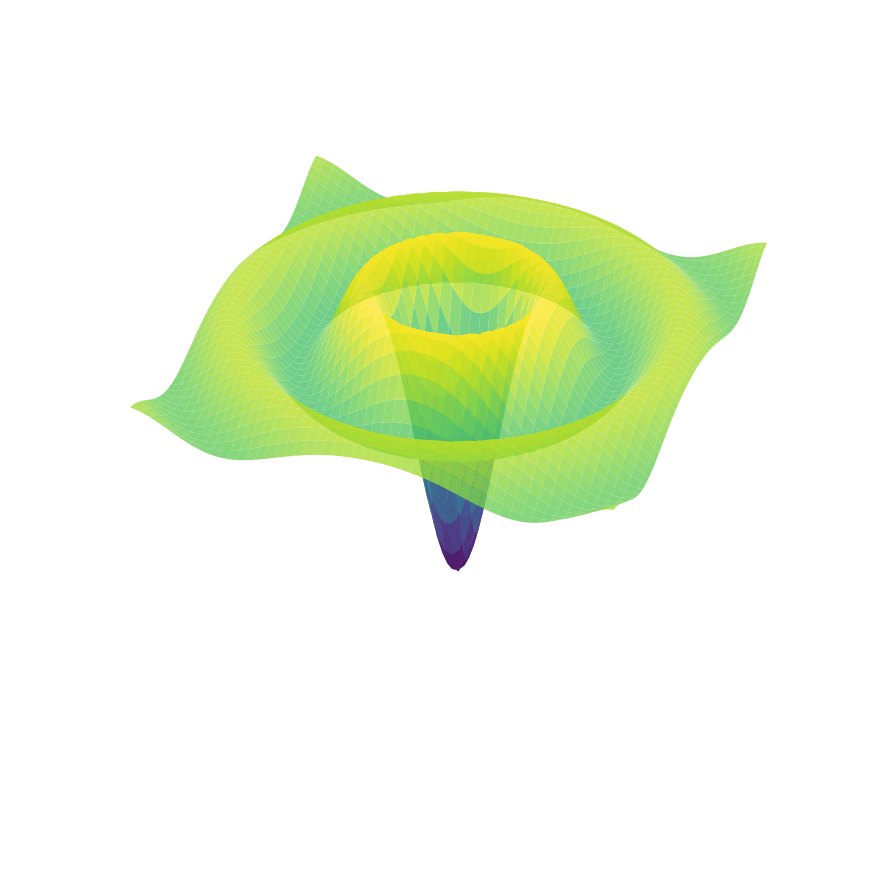

In [28]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection="3d")

factor = 6
scan2D_result = perform_2D_scan(all_final_parameters[0], loss_function, 
                                   direction_x=hess.eigenvectors[0]*factor, 
                                   direction_y=hess.eigenvectors[1]*factor, 
                                    n_steps_x=100)
plot_2D_scan_result_as_3D(scan2D_result, ax=ax)
ax.set_zlim(loss_limits)
ax.tick_params(labelsize=14)
ax.set_xlabel("Scan Direction x", fontsize=15)
ax.set_ylabel("Scan Direction y", fontsize=15)
ax.set_zlabel("Loss", fontsize=18, rotation=90)
plt.tight_layout()
ax._axis3don = False

plt.show()


### The End